In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_beam_FEKO as rf
import ultranest


In [2]:
o = rf.read_beam_FEKO('nominal.out',0)

 Frequency in Hz:               FREQ =    2.50000E+07

 Frequency in Hz:               FREQ =    2.60000E+07

 Frequency in Hz:               FREQ =    2.70000E+07

 Frequency in Hz:               FREQ =    2.80000E+07

 Frequency in Hz:               FREQ =    2.90000E+07

 Frequency in Hz:               FREQ =    3.00000E+07

 Frequency in Hz:               FREQ =    3.10000E+07

 Frequency in Hz:               FREQ =    3.20000E+07

 Frequency in Hz:               FREQ =    3.30000E+07

 Frequency in Hz:               FREQ =    3.40000E+07

 Frequency in Hz:               FREQ =    3.50000E+07

 Frequency in Hz:               FREQ =    3.60000E+07

 Frequency in Hz:               FREQ =    3.70000E+07

 Frequency in Hz:               FREQ =    3.80000E+07

 Frequency in Hz:               FREQ =    3.90000E+07

 Frequency in Hz:               FREQ =    4.00000E+07

 Frequency in Hz:               FREQ =    4.10000E+07

 Frequency in Hz:               FREQ =    4.20000E+07

 Frequency

In [3]:
theta = 90 - o[2]
phi = o[1]
freq = o[0]
theta, phi = np.meshgrid(theta, phi)

In [4]:
xx = theta
yy = phi
sigma = 100
def Acos(R, theta, miu, nu):
    part1 = np.cos(miu*theta*np.pi/180)*(R/sigma)**miu
    part2 = P(miu,nu,R**2/sigma**2)
    part3 = np.exp(-R**2/(4*sigma**2))
    return part1*part2*part3

def Asin(R, theta, miu, nu):
    part1 = np.sin(miu*theta*np.pi/180)*(R/sigma)**miu
    part2 = P(miu,nu,R**2/sigma**2)
    part3 = np.exp(-R**2/(4*sigma**2))
    return part1*part2*part3

def P(miu,nu,u):
    returnarray = np.ones([360,91])
    for i in range(360):
        for j in range(91):
            terms = []
            p = 0
            while p <= nu:
                up = np.math.factorial(miu + nu)*np.math.factorial(nu)
                down = np.math.factorial(miu + p)*np.math.factorial(p)*np.math.factorial(nu-p)
                term = (-2)**(nu-p)* up/down * u[i][j]**p
                terms.append(term)
                p += 1
            returnarray[i][j] = np.sum(terms)
    return returnarray

#Normalization
def normalize(array):
    q = 0
    theta = 0
    while theta <= 90:
        for i in range(360):
            q += (array[theta*360 + i])**2 * (np.pi/180)**2 * np.sin(theta*np.pi/180)
        theta += 1
    return array/q

def TDH(rank):
    """return matrix A = [f1, f2, f3, ...] for rank 0 to rank TDH functions"""
    zz00c = Acos(xx, yy, 0, 0)
    zz00c2d = zz00c.flatten()
    array = normalize(zz00c2d)
    r = 1
    while r <= rank:
        m = 0
        while m <= r:
            if (r - m)%2 == 0:
                n = (r - m)/2
                if m == 0:
                    cosine = Acos(xx,yy,m,n).T
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    array = np.vstack((array, ncos))
                    m += 2
                else:
                    cosine = Acos(xx,yy,m,n).T
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    sine = Asin(xx,yy,m,n).T
                    sine2d = sine.flatten()
                    nsin = normalize(sine2d)
                    array = np.vstack((array, ncos))
                    array = np.vstack((array, nsin))
                    m += 2
            else:
                m += 1
        r += 1
    matrix = np.matrix(array).T
    return matrix

def model(rank, coe):
    A = TDH(rank)
    a = np.matrix(coe).T
    return np.matmul(A,a)

def simulation(coe, sigma):
    rank = 0
    count = 1
    length = len(coe) - 1
    while length > count:
        rank += 1
        count += rank + 1
    mo = model(rank,coe)
    noise = np.random.default_rng().normal(0.0, sigma*np.max(mo),360*91)
    noi = np.matrix(noise).T
    data = mo + noi
    return data

def solve(A, data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    half = np.matmul(ATAinverse,AT)
    x = np.matmul(half,data)
    return x

def residual(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = fittingmodel - data
    return r

def residual2D(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = fittingmodel - data
    r2D = r.reshape(360,91)
    return r2D

def covariance(A,data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    r = residual(A,data)
    rT = r.T
    rTr = np.matmul(rT,r)
    s = rTr/((len(data))-10)
    s2 = s.item(0)
    covariance = s2*ATAinverse
    return covariance

In [5]:
rank0 = TDH(0)

In [6]:
rank02d = rank0.reshape(360,91)

In [7]:
slice1 = rank02d[0]
slice1 = np.array(slice1)
slice1 = slice1[0]

In [8]:
x = np.arange(0,91,1)

In [9]:
def Gaussian(A, sigx):
    return A * np.exp(-(x-90)**2/2/sigx**2) 

In [10]:
# Define model to simulate data
def model1(paras):
    A, sigx = paras
    return Gaussian(A,sigx)

In [11]:
sigma1 = np.std(slice1)
param_names = ['A', 'sigx']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 20
    params[0] = cube[0] * (hi - lo) + lo

    lo = 1
    hi = 200
    params[1] = cube[1] * (hi - lo) + lo

    return params
def my_likelihood(params):
    mo = model1(params)
    diff = mo - slice1
    return -0.5 * np.sum((diff/sigma1)**2)

In [12]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)

In [13]:
result = sampler.run(min_num_live_points=200)
sampler.print_results()

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0114..-0.0113]*| it/evals=3195/4914 eff=67.7768% N=200        0  0  0 0   0 0  0 
[ultranest] Likelihood function evaluations: 4916
[ultranest]   logZ = -11.42 +- 0.135
[ultranest] Effective samples strategy satisfied (ESS = 796.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -11.384 +- 0.323
  single instance: logZ = -11.384 +- 0.228
  bootstrapped   : logZ = -11.419 +- 0.322
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : 0.1722│ ▁ ▁ ▁▁▁▁▁▁▁▁▂▃▅▄▅▆▆▇▇▇▆▆▅▃▃▃▂▂▁▁▁▁▁▁▁ │0.1850    0.1792 +- 0.0016
    sigx                : 115.4 │ ▁▁▁▁▁▁▁▂▃▄▅▅▅▅▅▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁ │185.7     143.2 +- 7.9



TypeError: model() missing 1 required positional argument: 'coe'

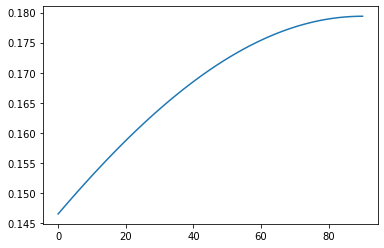

In [14]:
plt.plot(slice1)
plt.plot(model([8.06,1.47]))

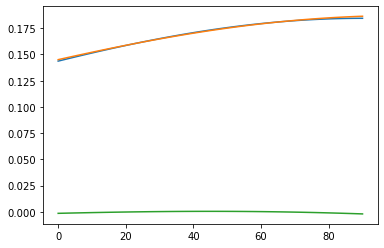

In [186]:
residual = slice1 - model([0.1871,143,102])
plt.plot(slice1)
plt.plot(model([0.1871,143,102]))
plt.plot(residual)

In [15]:
sigmatotal = range(1,90)
sigxtotal = []
residualtotal = []
for i in sigmatotal:
    sigma = i
    A = TDH(0).reshape(360,91)
    slice1 = A[0]
    slice1 = np.array(slice1)
    sigma1 = np.std(slice1)
    param_names = ['A', 'sigx']
    def my_prior_transform(cube):
        params = cube.copy()

        # transform location parameter: uniform prior
        lo = 0
        hi = 20
        params[0] = cube[0] * (hi - lo) + lo

        lo = 1
        hi = 200
        params[1] = cube[1] * (hi - lo) + lo

        return params
    def my_likelihood(params):
        mo = model1(params)
        diff = mo - slice1
        return -0.5 * np.sum((diff/sigma1)**2)
    sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
    result = sampler.run(min_num_live_points=200)
    sigx = np.average((result["samples"].T)[1])
    sigxtotal.append(sigx)
    a = np.average((result["samples"].T)[0])
    residual = slice1 - model1([a,sigx])
    residualtotal.append(residual)

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  0.0091..-0.0091]*| it/evals=2565/4853 eff=55.1257% N=200        0 0 
[ultranest] Likelihood function evaluations: 4860
[ultranest]   logZ = -8.221 +- 0.119
[ultranest] Effective samples strategy satisfied (ESS = 800.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0117..-0.0117]*| it/evals=2520/4377 eff=60.3304% N=200       0 0  
[ultranest] Likelihood function evaluations: 4380
[ultranest]   logZ = -7.978 +- 0.1123
[ultranest] Effective samples strategy satisfied (ESS = 814.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-05  0.0090..-0.0090]*| it/evals=2500/4143 eff=63.4035% N=200       0 0  
[ultranest] Likelihood function evaluations: 4164
[ultranest]   logZ = -7.949 +- 0.1434
[ultranest] Effective samples strategy satisfied (ESS = 810.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0096..-0.0096]*| it/evals=2480/4298 eff=60.5173% N=200    0  0 0  0 
[ultranest] Likelihood function evaluations: 4316
[ultranest]   logZ = -7.859 +- 0.1389
[ultranest] Effective samples strategy satisfied (ESS = 800.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0075..-0.0075]*| it/evals=2480/4310 eff=60.3406% N=200  0    0   0 
[ultranest] Likelihood function evaluations: 4332
[ultranest]   logZ = -7.915 +- 0.1552
[ultranest] Effective samples strategy satisfied (ESS = 785.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0085..-0.0085]*| it/evals=2520/4192 eff=63.1263% N=200  0 0  0 0 0  
[ultranest] Likelihood function evaluations: 4197
[ultranest]   logZ = -8.002 +- 0.1258
[ultranest] Effective samples strategy satisfied (ESS = 790.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-06  0.0062..-0.0062]*| it/evals=2565/4540 eff=59.1014% N=200    0  0 0 0  
[ultranest] Likelihood function evaluations: 4558
[ultranest]   logZ = -8.3 +- 0.1391
[ultranest] Effective samples strategy satisfied (ESS = 811.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0079..-0.0079]*| it/evals=2560/4083 eff=65.9284% N=200    0  0 0 0  
[ultranest] Likelihood function evaluations: 4089
[ultranest]   logZ = -8.218 +- 0.1237
[ultranest] Effective samples strategy satisfied (ESS = 782.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0127..-0.0127]*| it/evals=2500/4065 eff=64.6831% N=200    0  0 0 0 0 
[ultranest] Likelihood function evaluations: 4082
[ultranest]   logZ = -7.892 +- 0.1321
[ultranest] Effective samples strategy satisfied (ESS = 801.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0142..-0.0141]*| it/evals=2540/4177 eff=63.8672% N=200       0 0 0 0 
[ultranest] Likelihood function evaluations: 4196
[ultranest]   logZ = -8.119 +- 0.1502
[ultranest] Effective samples strategy satisfied (ESS = 815.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  .0091..-0.0090]*| it/evals=2600/4351 eff=62.6355% N=200      0     0 0 
[ultranest] Likelihood function evaluations: 4353
[ultranest]   logZ = -8.374 +- 0.1341
[ultranest] Effective samples strategy satisfied (ESS = 806.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0106..-0.0105]*| it/evals=2565/4204 eff=64.0609% N=200    0 0    0 0 0 
[ultranest] Likelihood function evaluations: 4206
[ultranest]   logZ = -8.255 +- 0.1405
[ultranest] Effective samples strategy satisfied (ESS = 816.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-05  0.0121..-0.0121]*| it/evals=2610/4290 eff=63.8142% N=200    0 0    0 0  
[ultranest] Likelihood function evaluations: 4296
[ultranest]   logZ = -8.48 +- 0.1626
[ultranest] Effective samples strategy satisfied (ESS = 804.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  0.0073..-0.0073]*| it/evals=2610/4195 eff=65.3317% N=200     0 0   0 0  
[ultranest] Likelihood function evaluations: 4196
[ultranest]   logZ = -8.433 +- 0.159
[ultranest] Effective samples strategy satisfied (ESS = 824.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0003  .0137..-0.0137]*| it/evals=2640/4416 eff=62.6186% N=200  0 0 0   00 0  
[ultranest] Likelihood function evaluations: 4424
[ultranest]   logZ = -8.622 +- 0.1733
[ultranest] Effective samples strategy satisfied (ESS = 792.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0083..-0.0083]*| it/evals=2565/4223 eff=63.7584% N=200      0    0 0  
[ultranest] Likelihood function evaluations: 4242
[ultranest]   logZ = -8.269 +- 0.1273
[ultranest] Effective samples strategy satisfied (ESS = 818.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  0.0103..-0.0103]*| it/evals=2640/4205 eff=65.9176% N=200  0   0  0  00   
[ultranest] Likelihood function evaluations: 4226
[ultranest]   logZ = -8.653 +- 0.1394
[ultranest] Effective samples strategy satisfied (ESS = 815.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-06  0.0086..-0.0085]*| it/evals=2600/4255 eff=64.1184% N=200    0 0  0 00   
[ultranest] Likelihood function evaluations: 4257
[ultranest]   logZ = -8.423 +- 0.1413
[ultranest] Effective samples strategy satisfied (ESS = 816.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-07  0.0081..-0.0081]*| it/evals=2640/4233 eff=65.4600% N=200      0  0 0    
[ultranest] Likelihood function evaluations: 4246
[ultranest]   logZ = -8.662 +- 0.1376
[ultranest] Effective samples strategy satisfied (ESS = 825.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0087..-0.0086]*| it/evals=2640/4384 eff=63.0975% N=200  0   0   0 00   
[ultranest] Likelihood function evaluations: 4389
[ultranest]   logZ = -8.603 +- 0.1198
[ultranest] Effective samples strategy satisfied (ESS = 787.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0123..-0.0123]*| it/evals=2740/4449 eff=64.4858% N=200       00  0   0 
[ultranest] Likelihood function evaluations: 4461
[ultranest]   logZ = -9.112 +- 0.1469
[ultranest] Effective samples strategy satisfied (ESS = 817.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0125..-0.0125]*| it/evals=2720/4405 eff=64.6849% N=200       0 0 00   0 
[ultranest] Likelihood function evaluations: 4410
[ultranest]   logZ = -9.009 +- 0.1542
[ultranest] Effective samples strategy satisfied (ESS = 808.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0118..-0.0118]*| it/evals=2720/4398 eff=64.7928% N=200    0    0 0   00 
[ultranest] Likelihood function evaluations: 4399
[ultranest]   logZ = -8.989 +- 0.1654
[ultranest] Effective samples strategy satisfied (ESS = 812.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0084..-0.0084]*| it/evals=2640/4235 eff=65.4275% N=200  0   0  0 0   00 
[ultranest] Likelihood function evaluations: 4259
[ultranest]   logZ = -8.72 +- 0.1431
[ultranest] Effective samples strategy satisfied (ESS = 819.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-06  0.0131..-0.0130]*| it/evals=2720/4323 eff=65.9714% N=200         0 0  0 0  
[ultranest] Likelihood function evaluations: 4342
[ultranest]   logZ = -9.056 +- 0.1562
[ultranest] Effective samples strategy satisfied (ESS = 800.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  0.0120..-0.0119]*| it/evals=2790/4628 eff=63.0081% N=200      0 00  0 0    
[ultranest] Likelihood function evaluations: 4633
[ultranest]   logZ = -9.422 +- 0.1659
[ultranest] Effective samples strategy satisfied (ESS = 822.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0111..-0.0110]*| it/evals=2740/4525 eff=63.3526% N=200        0  0   00 
[ultranest] Likelihood function evaluations: 4527
[ultranest]   logZ = -9.098 +- 0.1834
[ultranest] Effective samples strategy satisfied (ESS = 798.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-06  0.0101..-0.0100]*| it/evals=2720/4395 eff=64.8391% N=200      0 0  0  0 0  
[ultranest] Likelihood function evaluations: 4402
[ultranest]   logZ = -9.096 +- 0.16
[ultranest] Effective samples strategy satisfied (ESS = 791.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-06  0.0103..-0.0102]*| it/evals=2745/4634 eff=61.9080% N=200      0 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 4640
[ultranest]   logZ = -9.151 +- 0.1512
[ultranest] Effective samples strategy satisfied (ESS = 790.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0091..-0.0091]*| it/evals=2800/4789 eff=61.0155% N=200        0  00 0 0 0 
[ultranest] Likelihood function evaluations: 4797
[ultranest]   logZ = -9.44 +- 0.1518
[ultranest] Effective samples strategy satisfied (ESS = 783.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0136..-0.0135]*| it/evals=2680/4356 eff=64.4851% N=200        0  00 0 0 0 
[ultranest] Likelihood function evaluations: 4385
[ultranest]   logZ = -8.836 +- 0.1398
[ultranest] Effective samples strategy satisfied (ESS = 808.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  .0092..-0.0092]*| it/evals=2760/4506 eff=64.0966% N=200        0  0 0  0 0 
[ultranest] Likelihood function evaluations: 4508
[ultranest]   logZ = -9.159 +- 0.1442
[ultranest] Effective samples strategy satisfied (ESS = 806.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0099..-0.0098]*| it/evals=2800/4690 eff=62.3608% N=200    0   0 0 0   0 0  
[ultranest] Likelihood function evaluations: 4704
[ultranest]   logZ = -9.45 +- 0.1542
[ultranest] Effective samples strategy satisfied (ESS = 804.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0084..-0.0084]*| it/evals=2790/4403 eff=66.3812% N=200        0 0    0 0  
[ultranest] Likelihood function evaluations: 4406
[ultranest]   logZ = -9.364 +- 0.1495
[ultranest] Effective samples strategy satisfied (ESS = 770.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  0.0105..-0.0105]*| it/evals=2800/4480 eff=65.4206% N=200    0   0 0 0   0 0  
[ultranest] Likelihood function evaluations: 4507
[ultranest]   logZ = -9.501 +- 0.1469
[ultranest] Effective samples strategy satisfied (ESS = 776.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0100..-0.0099]*| it/evals=2820/4518 eff=65.3080% N=200        0 0     0 0  
[ultranest] Likelihood function evaluations: 4528
[ultranest]   logZ = -9.489 +- 0.1429
[ultranest] Effective samples strategy satisfied (ESS = 821.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0112..-0.0112]*| it/evals=2840/4498 eff=66.0772% N=200    0     0    0  0  
[ultranest] Likelihood function evaluations: 4507
[ultranest]   logZ = -9.621 +- 0.1593
[ultranest] Effective samples strategy satisfied (ESS = 814.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0126..-0.0126]*| it/evals=2920/5003 eff=60.7953% N=200       0 0  0  0    
[ultranest] Likelihood function evaluations: 5006
[ultranest]   logZ = -10.02 +- 0.1584
[ultranest] Effective samples strategy satisfied (ESS = 799.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0155..-0.0154]*| it/evals=2860/4884 eff=61.0589% N=200    0   0 0    0  0  
[ultranest] Likelihood function evaluations: 4900
[ultranest]   logZ = -9.788 +- 0.187
[ultranest] Effective samples strategy satisfied (ESS = 818.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-05  0.0110..-0.0109]*| it/evals=2880/4867 eff=61.7099% N=200     0  0   0  0    
[ultranest] Likelihood function evaluations: 4879
[ultranest]   logZ = -9.901 +- 0.13
[ultranest] Effective samples strategy satisfied (ESS = 770.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-06  -0.0106..-0.0104]*| it/evals=2900/4609 eff=65.7746% N=200       0   0   0 0  
[ultranest] Likelihood function evaluations: 4620
[ultranest]   logZ = -9.916 +- 0.1383
[ultranest] Effective samples strategy satisfied (ESS = 818.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-06  -0.0110..-0.0110]*| it/evals=2940/4766 eff=64.3890% N=200   0 0 00     00 0  
[ultranest] Likelihood function evaluations: 4771
[ultranest]   logZ = -10.17 +- 0.1344
[ultranest] Effective samples strategy satisfied (ESS = 815.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.15 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  .0076..-0.0076]*| it/evals=2860/4921 eff=60.5804% N=200       00 0   0 0   0 
[ultranest] Likelihood function evaluations: 4928
[ultranest]   logZ = -9.667 +- 0.1443
[ultranest] Effective samples strategy satisfied (ESS = 769.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  -0.0120..-0.0120]*| it/evals=2940/4831 eff=63.4852% N=200       0  00   0   0 
[ultranest] Likelihood function evaluations: 4841
[ultranest]   logZ = -10.12 +- 0.1623
[ultranest] Effective samples strategy satisfied (ESS = 836.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  0.0072..-0.0072]*| it/evals=2900/4802 eff=63.0161% N=200        0 0  00 00  0 
[ultranest] Likelihood function evaluations: 4803
[ultranest]   logZ = -9.938 +- 0.181
[ultranest] Effective samples strategy satisfied (ESS = 851.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  0.0102..-0.0102]*| it/evals=2880/4731 eff=63.5621% N=200        0 0   0 0   0 
[ultranest] Likelihood function evaluations: 4757
[ultranest]   logZ = -9.884 +- 0.1601
[ultranest] Effective samples strategy satisfied (ESS = 838.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-06  -0.0112..-0.0112]*| it/evals=2980/4679 eff=66.5327% N=200       0 0 0  0   0 
[ultranest] Likelihood function evaluations: 4685
[ultranest]   logZ = -10.37 +- 0.1699
[ultranest] Effective samples strategy satisfied (ESS = 814.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0132..-0.0131]*| it/evals=2920/4650 eff=65.6180% N=200       0 0 00  0 0 0  
[ultranest] Likelihood function evaluations: 4655
[ultranest]   logZ = -10.02 +- 0.1498
[ultranest] Effective samples strategy satisfied (ESS = 809.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0100..-0.0100]*| it/evals=2925/4878 eff=62.5267% N=200    0  0 0 0   0 0 0   
[ultranest] Likelihood function evaluations: 4890
[ultranest]   logZ = -10.1 +- 0.1578
[ultranest] Effective samples strategy satisfied (ESS = 826.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  0.0107..-0.0107]*| it/evals=2840/4651 eff=63.8059% N=200    00  0 0 0   0   0 
[ultranest] Likelihood function evaluations: 4675
[ultranest]   logZ = -9.699 +- 0.1493
[ultranest] Effective samples strategy satisfied (ESS = 793.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-05  -0.0104..-0.0103]*| it/evals=3000/5064 eff=61.6776% N=200       0 0 0  0 0 0  
[ultranest] Likelihood function evaluations: 5065
[ultranest]   logZ = -10.42 +- 0.1428
[ultranest] Effective samples strategy satisfied (ESS = 805.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  0.0107..-0.0105]*| it/evals=2880/4659 eff=64.5885% N=200        0 0 0  0 0 0 0 
[ultranest] Likelihood function evaluations: 4666
[ultranest]   logZ = -9.84 +- 0.1592
[ultranest] Effective samples strategy satisfied (ESS = 809.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0116..-0.0115]*| it/evals=2900/4826 eff=62.6891% N=200       0 0 0  0 0 00 0 
[ultranest] Likelihood function evaluations: 4839
[ultranest]   logZ = -9.934 +- 0.1336
[ultranest] Effective samples strategy satisfied (ESS = 762.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0096..-0.0096]*| it/evals=3020/4903 eff=64.2143% N=200   0   0 0 00 0  0 0 0 
[ultranest] Likelihood function evaluations: 4913
[ultranest]   logZ = -10.55 +- 0.152
[ultranest] Effective samples strategy satisfied (ESS = 817.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  0.0106..-0.0105]*| it/evals=2840/4689 eff=63.2658% N=200        0   0  0 0 0 0 
[ultranest] Likelihood function evaluations: 4704
[ultranest]   logZ = -9.691 +- 0.1416
[ultranest] Effective samples strategy satisfied (ESS = 798.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0129..-0.0128]*| it/evals=3000/4874 eff=64.1849% N=200    0    0  0 0    0 0 0 
[ultranest] Likelihood function evaluations: 4902
[ultranest]   logZ = -10.48 +- 0.1506
[ultranest] Effective samples strategy satisfied (ESS = 797.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0102..-0.0101]*| it/evals=2970/5173 eff=59.7225% N=200     0 0 0 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 5176
[ultranest]   logZ = -10.23 +- 0.17
[ultranest] Effective samples strategy satisfied (ESS = 782.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-06  -0.0085..-0.0084]*| it/evals=2925/5149 eff=59.1028% N=200           0  0  0 0 0  
[ultranest] Likelihood function evaluations: 5160
[ultranest]   logZ = -10.04 +- 0.1427
[ultranest] Effective samples strategy satisfied (ESS = 811.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0118..-0.0117]*| it/evals=3000/4821 eff=64.9210% N=200       0    0 0   00 0  
[ultranest] Likelihood function evaluations: 4834
[ultranest]   logZ = -10.45 +- 0.1698
[ultranest] Effective samples strategy satisfied (ESS = 808.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0102..-0.0101]*| it/evals=3040/5009 eff=63.2148% N=200       0    0  0 0 0 0  
[ultranest] Likelihood function evaluations: 5010
[ultranest]   logZ = -10.6 +- 0.1752
[ultranest] Effective samples strategy satisfied (ESS = 810.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0099..-0.0098]*| it/evals=3060/5008 eff=63.6439% N=200   0  0 0   0  0   0 0  
[ultranest] Likelihood function evaluations: 5027
[ultranest]   logZ = -10.79 +- 0.1868
[ultranest] Effective samples strategy satisfied (ESS = 832.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0083..-0.0083]*| it/evals=3040/5049 eff=62.6933% N=200       0   0 0    0  0  
[ultranest] Likelihood function evaluations: 5070
[ultranest]   logZ = -10.65 +- 0.2018
[ultranest] Effective samples strategy satisfied (ESS = 817.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-06  -0.0098..-0.0097]*| it/evals=3020/5083 eff=61.8472% N=200            0 0    0 00  
[ultranest] Likelihood function evaluations: 5091
[ultranest]   logZ = -10.52 +- 0.1521
[ultranest] Effective samples strategy satisfied (ESS = 818.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0117..-0.0116]*| it/evals=3040/5299 eff=59.6195% N=200       00   0 0    0  0  
[ultranest] Likelihood function evaluations: 5319
[ultranest]   logZ = -10.66 +- 0.1842
[ultranest] Effective samples strategy satisfied (ESS = 799.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0095..-0.0094]*| it/evals=3040/5153 eff=61.3769% N=200 0     0   0 0   00  0   
[ultranest] Likelihood function evaluations: 5167
[ultranest]   logZ = -10.65 +- 0.1379
[ultranest] Effective samples strategy satisfied (ESS = 787.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0117..-0.0116]*| it/evals=3040/4914 eff=64.4888% N=200    0  0 0 00    0 0     
[ultranest] Likelihood function evaluations: 4931
[ultranest]   logZ = -10.67 +- 0.1634
[ultranest] Effective samples strategy satisfied (ESS = 795.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-7e-05  -0.0090..-0.0089]*| it/evals=3080/5174 eff=61.9220% N=200   0   0   0  0        0  
[ultranest] Likelihood function evaluations: 5182
[ultranest]   logZ = -10.86 +- 0.1528
[ultranest] Effective samples strategy satisfied (ESS = 801.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-05  -0.0109..-0.0109]*| it/evals=3100/5361 eff=60.0659% N=200            0   0 200 0  
[ultranest] Likelihood function evaluations: 5369
[ultranest]   logZ = -10.91 +- 0.1772
[ultranest] Effective samples strategy satisfied (ESS = 799.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  -0.0105..-0.0105]*| it/evals=3020/4720 eff=66.8142% N=200           0  0    0 0 0  
[ultranest] Likelihood function evaluations: 4737
[ultranest]   logZ = -10.57 +- 0.1633
[ultranest] Effective samples strategy satisfied (ESS = 805.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0132..-0.0130]*| it/evals=3120/5007 eff=64.9053% N=200            0 0 0  0    0 
[ultranest] Likelihood function evaluations: 5033
[ultranest]   logZ = -11.08 +- 0.125
[ultranest] Effective samples strategy satisfied (ESS = 845.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0120..-0.0120]*| it/evals=3080/5070 eff=63.2444% N=200           0 0    0 0  
[ultranest] Likelihood function evaluations: 5089
[ultranest]   logZ = -10.87 +- 0.2139
[ultranest] Effective samples strategy satisfied (ESS = 822.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.21 tail:0.01 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0132..-0.0131]*| it/evals=3100/4819 eff=67.1141% N=200 0   0 0   0 0  0 00   
[ultranest] Likelihood function evaluations: 4819
[ultranest]   logZ = -10.92 +- 0.1793
[ultranest] Effective samples strategy satisfied (ESS = 827.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e-05  -0.0118..-0.0118]*| it/evals=3060/4928 eff=64.7208% N=200        0  0 0   00 0   00 
[ultranest] Likelihood function evaluations: 4957
[ultranest]   logZ = -10.82 +- 0.1588
[ultranest] Effective samples strategy satisfied (ESS = 796.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0102..-0.0102]*| it/evals=3060/4815 eff=66.3055% N=200       0   00 0  0 00  0 
[ultranest] Likelihood function evaluations: 4824
[ultranest]   logZ = -10.78 +- 0.1541
[ultranest] Effective samples strategy satisfied (ESS = 796.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-06  -0.0116..-0.0116]*| it/evals=3080/5336 eff=59.9688% N=200           0 0 00 0 0  00 
[ultranest] Likelihood function evaluations: 5352
[ultranest]   logZ = -10.83 +- 0.1442
[ultranest] Effective samples strategy satisfied (ESS = 805.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-06  -0.0111..-0.0110]*| it/evals=3105/4819 eff=67.2223% N=200    0   0   0   0  0   0 
[ultranest] Likelihood function evaluations: 4819
[ultranest]   logZ = -10.88 +- 0.1495
[ultranest] Effective samples strategy satisfied (ESS = 789.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0151..-0.0150]*| it/evals=3060/4910 eff=64.9682% N=200     0 0  00 0 0   0    0 
[ultranest] Likelihood function evaluations: 4926
[ultranest]   logZ = -10.83 +- 0.2071
[ultranest] Effective samples strategy satisfied (ESS = 827.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.21 tail:0.01 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-4e-05  -0.0090..-0.0089]*| it/evals=3160/5134 eff=64.0454% N=200        0    0 00  0  00 
[ultranest] Likelihood function evaluations: 5149
[ultranest]   logZ = -11.23 +- 0.1868
[ultranest] Effective samples strategy satisfied (ESS = 816.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0112..-0.0110]*| it/evals=3080/4883 eff=65.7698% N=200     0      0 0  0  0   0 
[ultranest] Likelihood function evaluations: 4883
[ultranest]   logZ = -10.81 +- 0.1327
[ultranest] Effective samples strategy satisfied (ESS = 859.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-3e-06  -0.0091..-0.0090]*| it/evals=3040/4834 eff=65.6021% N=200   0   0 0 0   00  0   200 
[ultranest] Likelihood function evaluations: 4837
[ultranest]   logZ = -10.6 +- 0.1411
[ultranest] Effective samples strategy satisfied (ESS = 790.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0102..-0.0102]*| it/evals=3160/4991 eff=65.9570% N=200        0  0  0 00 0   0 
[ultranest] Likelihood function evaluations: 5013
[ultranest]   logZ = -11.23 +- 0.1658
[ultranest] Effective samples strategy satisfied (ESS = 812.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.14 to 0.50, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-05  -0.0109..-0.0109]*| it/evals=3100/4871 eff=66.3669% N=200        0  0  00 0 0   0 
[ultranest] Likelihood function evaluations: 4897
[ultranest]   logZ = -10.93 +- 0.1431
[ultranest] Effective samples strategy satisfied (ESS = 801.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0002  0.0110..-0.0110]*| it/evals=3105/4954 eff=65.3134% N=200        0  0 0  0   0  00 
[ultranest] Likelihood function evaluations: 4972
[ultranest]   logZ = -11.01 +- 0.1732
[ultranest] Effective samples strategy satisfied (ESS = 809.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.44+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-6e-06  -0.0106..-0.0106]*| it/evals=3100/4986 eff=64.7723% N=200   00   0  0 0 0  0 0 0 0  
[ultranest] Likelihood function evaluations: 4987
[ultranest]   logZ = -10.92 +- 0.1342
[ultranest] Effective samples strategy satisfied (ESS = 782.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e-05  -0.0094..-0.0094]*| it/evals=3080/4788 eff=67.1316% N=200           0 0 200  0 0 0 0 
[ultranest] Likelihood function evaluations: 4791
[ultranest]   logZ = -10.82 +- 0.1614
[ultranest] Effective samples strategy satisfied (ESS = 809.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e-05  -0.0109..-0.0108]*| it/evals=3080/5018 eff=63.9269% N=200    0   0   0 0 0  0 0 00 
[ultranest] Likelihood function evaluations: 5049
[ultranest]   logZ = -10.88 +- 0.1771
[ultranest] Effective samples strategy satisfied (ESS = 805.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-0.0001  0.0100..-0.0100]*| it/evals=3020/4853 eff=64.9044% N=200          00 0 0  0 0  00 
[ultranest] Likelihood function evaluations: 4863
[ultranest]   logZ = -10.53 +- 0.1256
[ultranest] Effective samples strategy satisfied (ESS = 766.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-8e-06  -0.0125..-0.0123]*| it/evals=3100/4966 eff=65.0441% N=200        0   0 0 0  0  0 00 
[ultranest] Likelihood function evaluations: 4987
[ultranest]   logZ = -10.98 +- 0.1842
[ultranest] Effective samples strategy satisfied (ESS = 803.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-9e-06  -0.0107..-0.0106]*| it/evals=3180/5171 eff=63.9710% N=200         0 0    0  0  0  0  
[ultranest] Likelihood function evaluations: 5178
[ultranest]   logZ = -11.34 +- 0.187
[ultranest] Effective samples strategy satisfied (ESS = 806.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.


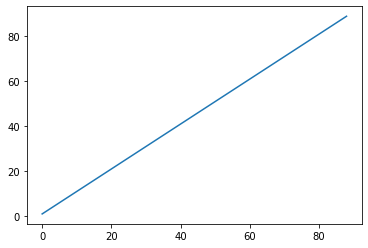

In [290]:
plt.plot(sigmatotal)

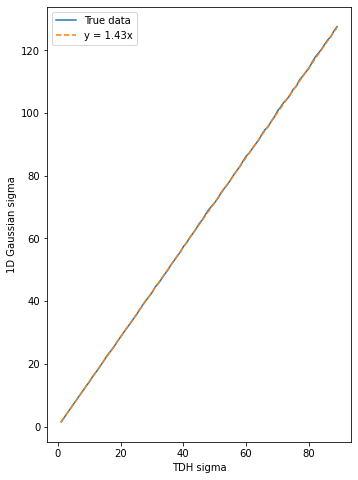

In [24]:
plt.figure(figsize = (8,8))
plt.plot(sigmatotal, sigxtotal, label = "True data")
plt.plot(sigmatotal, 1.43*np.array(sigmatotal), label = 'y = 1.43x', linestyle = 'dashed')
plt.xlabel("TDH sigma")
plt.ylabel("1D Gaussian sigma")
plt.legend()
plt.axis('scaled')
plt.savefig("sigma relation")

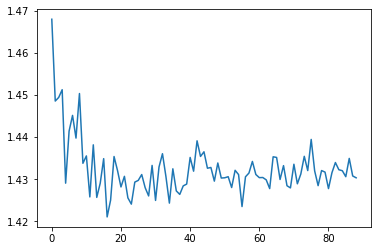

In [294]:
plt.plot(np.array(sigxtotal)/np.array(sigmatotal))

In [295]:
np.average(np.array(sigxtotal)/np.array(sigmatotal))

1.4325556634750685